# USDA Food Data - Preliminary Analysis

USDA Food Data is obtained from a consolidated dataset published by the Open Food Facts organization (https://world.openfoodfacts.org/) and made available on the Kaggle website (https://www.kaggle.com/openfoodfacts/world-food-facts). 

Open Food Facts is a free, open, collbarative database of food products from around the world, with ingredients, allergens, nutrition facts and all the tidbits of information we can find on product labels (source: ://www.kaggle.com/openfoodfacts/world-food-facts). 

Link to the available data can be found here - https://www.kaggle.com/openfoodfacts/world-food-facts/downloads/en.openfoodfacts.org.products.tsv

For the purpose of our analysis we will only be looking at USDA data and not data sourced from other countries since the USDA data appears to be the dataset that is well populated with values.

## Loading the data

In [14]:
# load pre-requisite imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from gensim import corpora, models, similarities

ValueError: numpy.dtype has the wrong size, try recompiling. Expected 88, got 96

In [3]:
# load world food data into a pandas dataframe
world_food_facts =pd.read_csv("../w209finalproject_data/data/en.openfoodfacts.org.products.tsv", sep='\t',low_memory=False)

# extract USDA data from world data
usda_import = world_food_facts[world_food_facts.creator=="usda-ndb-import"]

# save the usda data to a csv file
usda_import.to_csv("../w209finalproject_data/data/usda_imports_v2.csv")

## Preliminary look at the USDA data

In [4]:
# Examining available fields
print("Number of records:",len(usda_import))
print("Number of columns:",len(list(usda_import)))

print("\nField Names:")
list(usda_import)

len(usda_import)

('Number of records:', 169868)
('Number of columns:', 162)

Field Names:


169868

## Quick look at a few of the rows

Each row contains fields that specify the value for a given nutrient. Note that only those fields with valid values are populated. The others are empty.

In [5]:
usda_import_subset = usda_import.head(1)
print "Code:",usda_import_subset['code'][1]
print "Product Name:",usda_import_subset['product_name'][1]
print "Ingredients:",usda_import_subset['ingredients_text'][1]
print "Sugar 100g",usda_import_subset['sugars_100g'][1]
print "Vitamin A 100g",usda_import_subset['vitamin-a_100g'][1]

Code: 0000000004530
Product Name: Banana Chips Sweetened (Whole)
Ingredients: Bananas, vegetable oil (coconut oil, corn oil and/or palm oil) sugar, natural banana flavor.
Sugar 100g 14.29
Vitamin A 100g 0.0


## Quick look at ingredients

Ingredients are not broken down similar to nutrients into separate fields. Rather, all ingredients are grouped together into a single line of text. 

In [6]:
usda_import['ingredients_text'].head(5)

1    Bananas, vegetable oil (coconut oil, corn oil ...
2    Peanuts, wheat flour, sugar, rice flour, tapio...
3    Organic hazelnuts, organic cashews, organic wa...
4                                      Organic polenta
5    Rolled oats, grape concentrate, expeller press...
Name: ingredients_text, dtype: object

In this step, we convert the ingredients text into a format that can be vectorized.

In [7]:
# Extracting ingredients for a particular product
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 600)

print "Vectorizable ingredients text"

for x in range(3):
    ingredients = re.split(',|\(|\)',usda_import['ingredients_text'].iloc[x])
    ingredients = [w.strip().replace(' ','-') for w in ingredients]
    print(' '.join(ingredients))

Vectorizable ingredients text
Bananas vegetable-oil coconut-oil corn-oil-and/or-palm-oil sugar natural-banana-flavor.
Peanuts wheat-flour sugar rice-flour tapioca-starch salt leavening ammonium-bicarbonate baking-soda  soy-sauce water soybeans wheat salt  potato-starch.
Organic-hazelnuts organic-cashews organic-walnuts-almonds organic-sunflower-oil sea-salt.


## Cleaning up the dataset

We now look at the available data in the dataset and look for possible issues with the data that could impact our analysis.

Notice that several entries are not full populated with all available nutrition.

Going by the results, we can limit the categories that we use for the analysis to just those over 100,000 values to ensure that we avoid having to work with columns that are not sufficiently populated. 

In [8]:
# Looking for columns that are not sufficiently populated

# display count of all rows
print("Total rows in USDA dataset are:",len(usda_import))

# display count of all non-NAN entries in each column
print("\nCount of non-NaN values in each column")

print(usda_import.count().sort_values(ascending=False))

('Total rows in USDA dataset are:', 169868)

Count of non-NaN values in each column
code                                          169868
states_en                                     169868
countries                                     169868
url                                           169868
creator                                       169868
created_t                                     169868
created_datetime                              169868
states_tags                                   169868
last_modified_t                               169868
last_modified_datetime                        169868
countries_tags                                169868
countries_en                                  169868
states                                        169868
additives_n                                   169867
ingredients_text                              169867
ingredients_from_palm_oil_n                   169867
ingredients_that_may_be_from_palm_oil_n       169867
serving_size   

## Looking for similar products based on ingredients

This section attempts to use item similarity to look for similar products based on ingredients present. We vectorize all ingredients and use the resulting vector to look for similar items.

In [9]:
# load the subsample USDA data
#usda_sample_data =pd.read_csv("./data/usda_imports_20k.csv", sep=',',low_memory=False)
#usda_sample_data =pd.read_csv("./data/usda_imports_v2_1000_hdr.csv", sep=',',low_memory=False)
usda_sample_data =pd.read_csv("../w209finalproject_data/data/usda_imports_v2.csv", sep=',',low_memory=False)

In [10]:
# add a new column that includes a modified version of ingredients list that can be vectorized
ingredients_list=[]

index = 0
for x in range(len(usda_sample_data)):
    str_to_split = usda_import['ingredients_text'].iloc[x]

    try:
        ingredients = re.split(',|\(|\)|\[|\]',str_to_split)
    except:
        ingredients = re.split(',|\(|\)|\[|\]',"None")
        
    ingredients = [w.strip().replace(' ','-') for w in ingredients]
    ingredients_str = ' '.join(ingredients)
    
    ingredients_list.append(ingredients_str)
    
    index+=1 
    
# add the new column to the dataframe
usda_sample_data['ingredients_list'] = ingredients_list

print(usda_sample_data['ingredients_list'])
    

0         Bananas vegetable-oil coconut-oil corn-oil-and...
1         Peanuts wheat-flour sugar rice-flour tapioca-s...
2         Organic-hazelnuts organic-cashews organic-waln...
3                                           Organic-polenta
4         Rolled-oats grape-concentrate expeller-pressed...
5                             Organic-long-grain-white-rice
6         Org-oats org-hemp-granola org-oats evaporated-...
7         Organic-chocolate-liquor organic-raw-cane-suga...
8         Organic-expeller-pressed refined-high-oleic-su...
9                                      Organic-adzuki-beans
10               Organic-refined-durum-semolina-wheat-flour
11        Roasted-peanuts peanuts peanut-or-canola-oil s...
12                                Organic-golden-flax-seeds
13        Organic-dry-roasted-pumpkin-seeds tamari soybe...
14        Organic-rolled-oats honey raisins almonds sunf...
15                                   Organic-raw-hazelnuts.
16        Organic-bananas organic-coconu

00 000 000079 0009 001 002 003 005 0051 006 008 0091 01 010 010000 011 0152 017 02 025 026212 03 04 045 046 05 054 055 05mg 06 07 071008 075 08 08g 0965 0fauta 0g 0il 10 100 1000ppm 1005 100g 100mg 100ml 100ppm 101 102 103


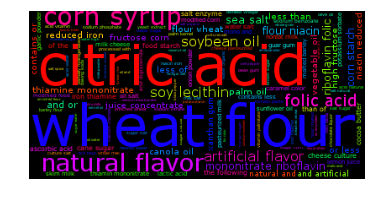

In [11]:
## Generate a word cloud for the ingredients

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# create a new column using a modified version of ingredients list that can be vectorized
vectorizer = CountVectorizer()

corpus_data=usda_sample_data['ingredients_list']
count_matrix = vectorizer.fit_transform(corpus_data)

# display the features/tokens 
all_feature_names = vectorizer.get_feature_names()
print(" ".join(list(all_feature_names[:50])))

%matplotlib inline

# generate wordcloud
from os import path
from scipy.misc.pilutil import imread
import matplotlib.pyplot as plt
import random

from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      relative_scaling = 1.0,
                      stopwords = 'to of the ,'
                      ).generate("".join(usda_sample_data['ingredients_list']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [12]:
# remove common words and tokenize the ingredients_list values
documents = usda_sample_data['ingredients_list']
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
          for document in documents]

# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
         frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
          for text in texts]

# display first 10 entries
from pprint import pprint  # pretty-printer
pprint(texts[:10])

[['bananas',
  'vegetable-oil',
  'coconut-oil',
  'corn-oil-and/or-palm-oil',
  'sugar',
  'natural-banana-flavor.'],
 ['peanuts',
  'wheat-flour',
  'sugar',
  'rice-flour',
  'tapioca-starch',
  'salt',
  'leavening',
  'ammonium-bicarbonate',
  'baking-soda',
  'soy-sauce',
  'water',
  'soybeans',
  'wheat',
  'salt',
  'potato-starch.'],
 ['organic-hazelnuts',
  'organic-cashews',
  'organic-sunflower-oil',
  'sea-salt.'],
 ['organic-polenta'],
 ['rolled-oats',
  'grape-concentrate',
  'expeller-pressed-canola-oil',
  'sunflower-seeds',
  'almonds',
  'sesame-seeds',
  'cashews',
  'natural-vitamin-e.'],
 ['organic-long-grain-white-rice'],
 ['org-oats',
  'org-oats',
  'evaporated-cane-juice',
  'crispy-rice',
  'org-evaporated-cane-juice',
  'sea-salt',
  'org-flax-seeds',
  'hemp-seeds',
  'org-coconut',
  'org-flax-seeds',
  'org-corn-meal',
  'sea-salt',
  'org-corn-meal',
  'org-evaporated-cane-juice',
  'sea-salt',
  'tocopherols',
  'natural-vitamin-e',
  '.'],
 ['organic-

In [ ]:
# generate and persist the dictionary
dictionary = corpora.Dictionary(texts)
dictionary.save('../w209finalproject_data/data/ingredients.dict')  # store the dictionary, for future reference

# generate and persist the corpus
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('../w209finalproject_data/data/ingredients.mm', corpus)  # store to disk, for later use
print(corpus[:10])

# generate and persist the index
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=-1)
index = similarities.MatrixSimilarity(lsi[corpus]) # transform corpus to LSI space and index it
index.save('.../w209finalproject_data/data/ingredients.index')

In [13]:
# load the dictionary and matrix representation of similarity and the index
dictionary = corpora.Dictionary.load('../w209finalproject_data/data/ingredients.dict')
corpus = corpora.MmCorpus('../w209finalproject_data/data/ingredients.mm') 

# load the index
index = similarities.MatrixSimilarity.load('../w209finalproject_data/data/ingredients.index')

NameError: name 'corpora' is not defined

In [ ]:
# convert query to vector
max_count=3
def displaySimilarProducts(query):

    vec_bow = dictionary.doc2bow(query.lower().split())
    vec_lsi = lsi[vec_bow] # convert the query to LSI space
    #print(vec_lsi)

    sims = index[vec_lsi]
    #print(list(enumerate(sims)))

    print "\nQuery String:",query

    sims_sorted = sorted(enumerate(sims), key=lambda item: -item[1])

    #print(sims_sorted)

    count=0
    print("Top 3 matches:")
    for sim in sims_sorted:
        print "\nCode:",usda_sample_data['code'][sim[0]]
        print "Product Name:",usda_sample_data['product_name'][sim[0]]
        print "Text:",usda_sample_data['ingredients_list'][sim[0]]
        print "Match:",sim[1]

        if count==max_count-1:
            break
        else:
            count+=1

In [ ]:
query=raw_input("Enter search text:")
displaySimilarProducts(query)